In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
import librosa
import numpy as np
from tqdm import tqdm
import librosa
import pickle
from pathlib import Path
import os

### Create folders and relavent paths

In [ ]:
classes = ['an arabiensis','culex pipiens complex','an funestus ss', 'ae aegypti','background'] #classes in folders.

In [ ]:
classes = {c: [] for c in classes}
classes

{'an arabiensis': [],
 'culex pipiens complex': [],
 'an funestus ss': [],
 'ae aegypti': [],
 'background': []}

In [ ]:
folders = os.listdir('drive/MyDrive/HumBug/Segmented') #we goolden
folders = [Path('drive/MyDrive/HumBug/Segmented')/folder for folder in folders]
folders

[PosixPath('drive/MyDrive/HumBug/Segmented/culex pipiens complex_seg'),
 PosixPath('drive/MyDrive/HumBug/Segmented/an funestus ss_seg'),
 PosixPath('drive/MyDrive/HumBug/Segmented/ae aegypti_seg'),
 PosixPath('drive/MyDrive/HumBug/Segmented/background_seg'),
 PosixPath('drive/MyDrive/HumBug/Segmented/an arabiensis_seg')]

### Method to load audio into the classes dictonary
run this if you have the segmented clips in directories...

In [ ]:
#load the segmented files from the google colab folders into each class dictonary respectivly
def loadFolderIntoClass(folder: Path):
  segments = []
  print(f"-Opening folder: {folder.name}")
  for i, clip in enumerate(folder.iterdir()):
    if clip.suffix == '.wav':
      try:
        segment, sr = librosa.load(clip, sr=None)
        segments.append(segment)
      except Exception as e:
        print(f"Didn't load: {clip.name}: {e}")

    if i % 2500 == 0:
      print(f"File: {folder.name}, Finished Loading {i} files.")
  print(f"-done with: {folder.name}")
  return folder.name[:-4], segments

if __name__ == "__main__":
  import multiprocessing
  with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
    results = pool.map(loadFolderIntoClass, folders)

-Opening folder: culex pipiens complex_seg-Opening folder: an funestus ss_seg

-done with: culex pipiens complex_seg
-done with: an funestus ss_seg
-Opening folder: ae aegypti_seg
-Opening folder: background_seg
-done with: ae aegypti_seg
-Opening folder: an arabiensis_seg
-done with: background_seg
-done with: an arabiensis_seg


In [ ]:
classes = {cls: segments for cls, segments in results}
classes.keys()

dict_keys(['culex pipiens complex', 'an funestus ss', 'ae aegypti', 'background', 'an arabiensis'])

In [ ]:
classesEncoding = {cls: i for i, cls in enumerate(classes.keys())}
classesEncoding

{'culex pipiens complex': 0,
 'an funestus ss': 1,
 'ae aegypti': 2,
 'background': 3,
 'an arabiensis': 4}

###pickled classes
run this if you have the segmented clips in a dictionary already

In [ ]:
#path to the pickled object
picklePath = "drive/MyDrive/processed_audio_data/MosquitoAudio.pkl"

In [ ]:
# # pickle classes to path
# import pickle
# with open(picklePath, 'wb') as f:
#     pickle.dump(classes, f)

In [ ]:
#load the pickled classes
import pickle
with open(picklePath, 'rb') as f:
    classes = pickle.load(f)

classesEncoding = {cls: i for i, cls in enumerate(classes.keys())}
classesEncoding

{'culex pipiens complex': 0,
 'an funestus ss': 1,
 'ae aegypti': 2,
 'background': 3,
 'an arabiensis': 4}

###Testing the resulting dictionary

In [ ]:
#info on the classes dictonary
print(classes.keys(), '\n')

for cls, segments in classes.items():
  print(f"{cls}: {len(segments)}")

print()

# print(f"\nEncoding of each class")
for cls, segments in classes.items():
  print(f"{cls}: {classesEncoding[cls]}")
print(f"\ntotal: {sum([len(segments) for cls, segments in classes.items()])}")

dict_keys(['culex pipiens complex', 'an funestus ss', 'ae aegypti', 'background', 'an arabiensis']) 

culex pipiens complex: 6733
an funestus ss: 6801
ae aegypti: 1139
background: 5555
an arabiensis: 12940

culex pipiens complex: 0
an funestus ss: 1
ae aegypti: 2
background: 3
an arabiensis: 4

total: 33168


In [ ]:
shapes = set()
types  = set()
for c, segments in classes.items():
  for segment in segments:
    shapes.add(segment.shape)
    types.add(type(segment))

print(shapes)
print(types)

{(16000,)}
{<class 'numpy.ndarray'>}


###Creating flat training arrays


In [ ]:
import random

#code to do train;test splilt with the classes dictonary
def split_classes_dict(classes, split_ratio=0.8, shuffle=True):
    train_dict, test_dict = {}, {}
    for cls, segments in classes.items():
        if shuffle:
            random.shuffle(segments)
        split_point = int(len(segments) * split_ratio)
        train_dict[cls] = segments[:split_point]
        test_dict[cls] = segments[split_point:]
    return train_dict, test_dict

def flatten_classes(classes_dict, label_to_index):
    data = []
    labels = []

    for cls_name, segment_list in classes_dict.items():
        class_index = classesEncoding[cls_name]
        for segment in segment_list:
            data.append(segment)
            labels.append(class_index)
    return data, labels

In [ ]:
#split the dictionaries, then flatten them to a list
trainClasses, testClasses = split_classes_dict(classes)

trainX, trainY = flatten_classes(trainClasses, classesEncoding)
testX, testY = flatten_classes(testClasses, classesEncoding)

In [ ]:
max = 0
min = 1
for x in trainX:
  if np.max(x) > max:
    max = np.max(x)

  if np.min(x) < min:
    min = np.min(x)

print(max, min)
#as we can see... all segments are in range of [-1, 1], when we deploy we have to normalize it too...

###Feature Extraction....
the manual mel-filterbanks energies

In [ ]:
# Define parameters
sample_rate = 16000
segment_length = 16000
window_duration = 0.025  # 25 ms
window_stride = 0.015  # 15 ms
FFT_length = 512
mel_bins = 40
fmin = 80
fmax = 2500

win_length = int(window_duration * sample_rate)
hop_length = int(window_stride * sample_rate)
time_frames = int((segment_length - win_length) / hop_length) + 1

In [ ]:
def mel_spectrogram(audio, label):
  spectrogram = tf.signal.stft(audio, frame_length=win_length, frame_step=hop_length, window_fn=tf.signal.hann_window, pad_end=False)
  magnitude   = tf.abs(spectrogram) #we don't need this since we're taking power=2 anyways | complex numbers .
  power       = tf.math.pow(magnitude, 2)

  mel_weights     = tf.signal.linear_to_mel_weight_matrix(
      num_mel_bins         = mel_bins,
      num_spectrogram_bins = power.shape[-1],
      sample_rate          = sample_rate,
      lower_edge_hertz     = fmin,
      upper_edge_hertz     = fmax
      )

  mel_spectrogram = tf.matmul(power, mel_weights)
  log_mel         = tf.math.log(mel_spectrogram + 1e-6)

  mel_spectrogram = tf.expand_dims(log_mel, axis=-1)  # Now shape = (time, 80, 1)
  return log_mel, label

###Creating the Datasets

In [ ]:
#create the datasets
batchsize = 32
trainDataset = tf.data.Dataset.from_tensor_slices((trainX, trainY))
testDataset = tf.data.Dataset.from_tensor_slices((testX, testY))

trainDataset = trainDataset.map(mel_spectrogram).shuffle(buffer_size=len(trainDataset)).batch(batchsize) #.map(mel_spectrogram)
trainDataset = trainDataset.prefetch(buffer_size=tf.data.AUTOTUNE)

testDataset = testDataset.map(mel_spectrogram).batch(batchsize)                                          #.map(mel_spectrogram)
testDataset = testDataset.prefetch(buffer_size=tf.data.AUTOTUNE)

###Create the model

In [ ]:
from tensorflow.keras import layers
def build_tiny_model(num_classes=5, input_shape=(time_frames, mel_bins,1)): #later on, delete this channel dimantion it's annoying
    inputs = keras.Input(shape=input_shape, name="mel_input")
    x = inputs

    # Block 1
    x = layers.SeparableConv2D(12, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2,2))(x)
    # x = layers.Dropout(0.1)(x)

    # Block 2
    x = layers.SeparableConv2D(24, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2,2))(x)
    # x = layers.Dropout(0.1)(x)

    # Block 3
    x = layers.SeparableConv2D(48, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2,2))(x)
    # x = layers.Dropout(0.1)(x)

    # Global pooling + light classifier
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)


###Train the model

In [ ]:
# import tensorflow_addons as tfa

model = build_tiny_model()
optimizer = keras.optimizers.AdamW(learning_rate=0.001)

model.compile(optimizer=optimizer, loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
class_sizes = {}
#loop over trainClasses and set class_sizes to the len() of trainClasses
for cls, segments in trainClasses.items():
    class_sizes[cls] = len(segments)

total = sum(class_sizes.values())
class_weights = {}
for cls, size in class_sizes.items():
    weight = total / (len(class_sizes) * size)
    class_weights[classesEncoding[cls]] = weight

# class_weights[0]+= 0.12
# class_weights[1]+= 0.19
# class_weights[4]-= 0.1 #risky a bit but we'll see...
print(class_sizes)


# for c in class_weights:
#   class_weights[c] *= 2
class_weights

{'culex pipiens complex': 5386, 'an funestus ss': 5440, 'ae aegypti': 911, 'background': 4444, 'an arabiensis': 10352}


{0: 0.9852580764946157,
 1: 0.9754779411764706,
 2: 5.825027442371021,
 3: 1.194104410441044,
 4: 0.5126159196290572}

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_loss',       # Metric to monitor
    patience=15,               # Stop after 5 epochs of no improvement
    restore_best_weights=True # Load best weights after stopping
)

In [ ]:
history = model.fit(
    trainDataset,
    validation_data=testDataset,
    epochs=100,
    class_weight=class_weights,
    callbacks=[early_stop])

Epoch 1/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.3556 - loss: 1.4154 - val_accuracy: 0.5679 - val_loss: 1.0625
Epoch 2/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5280 - loss: 1.0240 - val_accuracy: 0.5846 - val_loss: 0.9716
Epoch 3/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5735 - loss: 0.9255 - val_accuracy: 0.5781 - val_loss: 0.9642
Epoch 4/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5868 - loss: 0.8661 - val_accuracy: 0.5869 - val_loss: 0.9423
Epoch 5/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6072 - loss: 0.8455 - val_accuracy: 0.6621 - val_loss: 0.8045
Epoch 6/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6221 - loss: 0.8104 - val_accuracy: 0.6089 - val_loss: 0.9381
Epoch 7/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6278 - loss: 0.8062 - val_accuracy: 0.6413 - val_loss: 0.8191
Epoch 8/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6315 - loss: 0.7743 - val_ac

###Analyizing the model

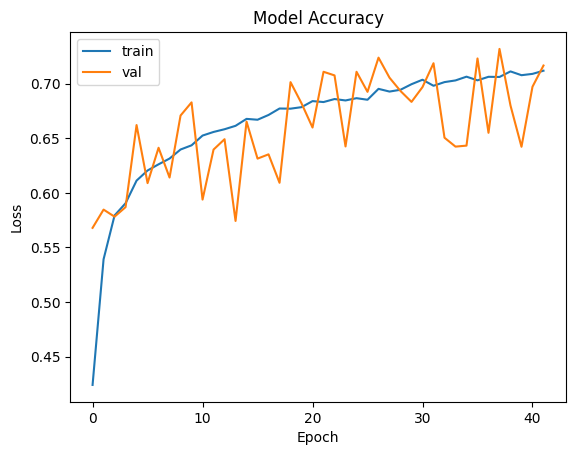

<function matplotlib.pyplot.show(close=None, block=None)>

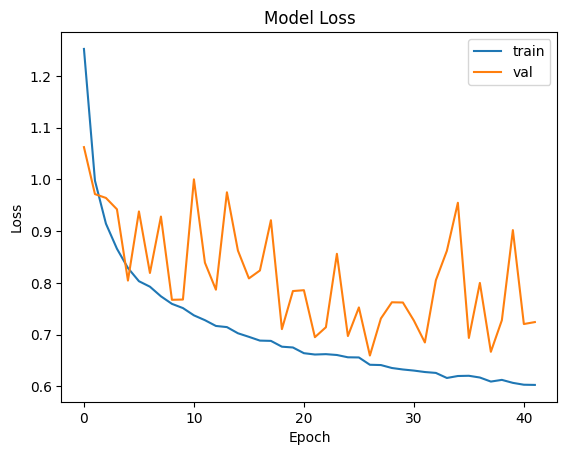

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#also plot loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show

208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


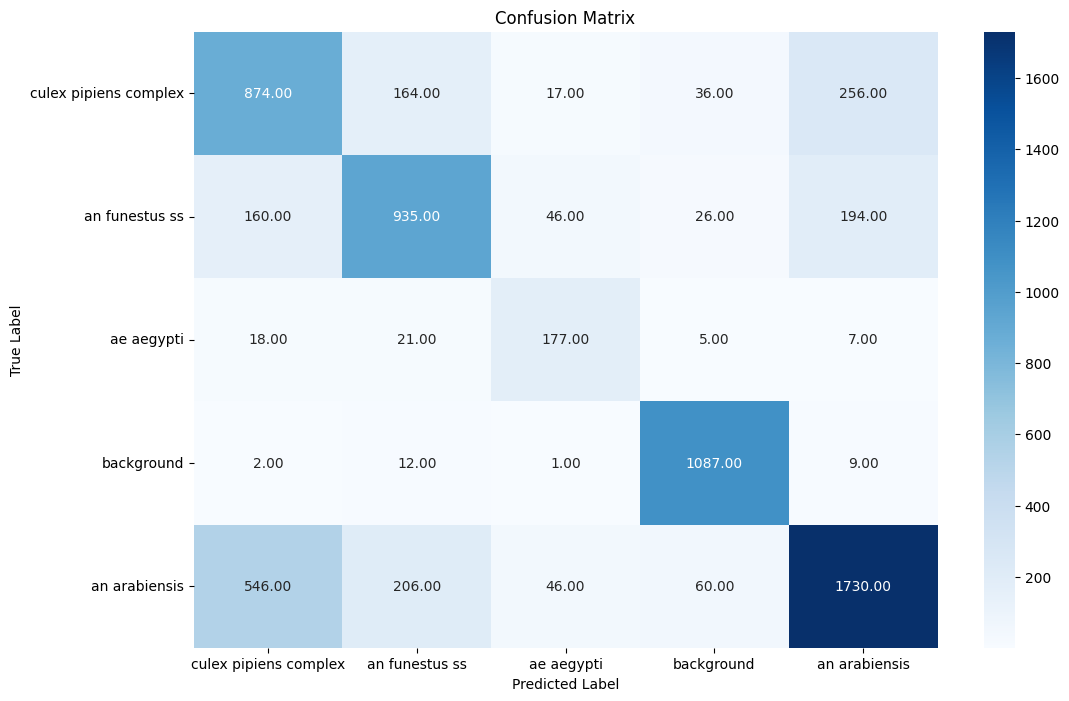

In [ ]:
import numpy as np

y_pred = model.predict(testDataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert softmax to class indices

y_true = np.concatenate([y for x, y in testDataset], axis=0)

clasess = [name for name, weight in class_weights.items()]

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

norm = False
if norm:
  cm = confusion_matrix(y_true, y_pred_classes, normalize='true')
  cm*= 100
else:
  cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels= classes,
            yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score
)


y_pred = model.predict(testDataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert softmax to class indices

y_true = np.concatenate([y for x, y in testDataset], axis=0)

# Basic overall metrics
print("📊 Overall Performance Metrics:")
print(f"Accuracy: {accuracy_score(y_true, y_pred_classes):.4f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_true, y_pred_classes):.4f}")
print(f"Macro Precision: {precision_score(y_true, y_pred_classes, average='macro'):.4f}")
print(f"Macro Recall: {recall_score(y_true, y_pred_classes, average='macro'):.4f}")
print(f"Macro F1-Score: {f1_score(y_true, y_pred_classes, average='macro'):.4f}")

# Detailed breakdown per class
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred_classes, digits=4))


208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
📊 Overall Performance Metrics:
Accuracy: 0.7239
Balanced Accuracy: 0.7518
Macro Precision: 0.7090
Macro Recall: 0.7518
Macro F1-Score: 0.7263

📋 Classification Report:
              precision    recall  f1-score   support

           0     0.5463    0.6488    0.5931      1347
           1     0.6988    0.6870    0.6928      1361
           2     0.6167    0.7763    0.6874       228
           3     0.8954    0.9784    0.9351      1111
           4     0.7878    0.6685    0.7232      2588

    accuracy                         0.7239      6635
   macro avg     0.7090    0.7518    0.7263      6635
weighted avg     0.7326    0.7239    0.7248      6635



###Quanatize and convert to .tflite

In [ ]:
def representative_dataset():
    for input_batch, _ in trainDataset.take(len(trainDataset)):
        for input_example in input_batch:
            input_example = input_example.numpy()
            input_example = input_example.astype(np.float32)
            input_example = np.expand_dims(input_example, axis=0)  # Add batch dimension
            input_example = np.expand_dims(input_example, axis=-1)  # Add batch dimension

            yield [input_example]

In [ ]:
model.trainable = False # I didn't know this was a thing in keras ...

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Use input/output INT8 quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS_INT8
]
converter.inference_input_type  = tf.int8   # or tf.uint8
converter.inference_output_type = tf.int8

converter.representative_dataset = representative_dataset

# Convert the model
tflite_model = converter.convert()

# Save the quantized TFLite model
with open('s1SeprableConvSoftmaxModel.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpho2b771u'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 66, 40, 1), dtype=tf.float32, name='mel_input')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  135566497168080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135566497164240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135566497166544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135566497165200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135566497166160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135566497163664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135566497167120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135566497167312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135566497166928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135566497167888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135566497168464: Te

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [ ]:
#summery of model
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mel_input (InputLayer)          │ (None, 66, 40, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_9              │ (None, 66, 40, 12)     │            33 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 66, 40, 12)     │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 66, 40, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 33, 20, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_10             │ (None, 33, 20, 24)     │           420 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 33, 20, 24)     │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 33, 20, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 10, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_11             │ (None, 16, 10, 48)     │         1,416 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 10, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 16, 10, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 8, 5, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 48)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,940 (15.39 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,938 (15.38 KB)

 Optimizer params: 2 (12.00 B)

In [ ]:
interpreter = tf.lite.Interpreter(model_path="s1SeprableConvSoftmaxModel.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
print(f"Scale: {input_details[0]['quantization'][0]}")
print(f"Zero point: {input_details[0]['quantization'][1]}")

Scale: 0.08258232474327087
Zero point: 39


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


###Save the model (just in case)

In [ ]:
#Manual save
model.save('s1SeprableConvSoftmaxModel.h5')  # Saves to HDF5 format

In [ ]:
#Manual load
from tensorflow.keras.models import load_model
model = load_model('s1SeprableConvSoftmaxModel.h5')


# Train Larger Models

### The humbug DB model!
I got this model straight from the HumBug DB paper


In [ ]:
from keras.models import Sequential
from keras.layers import Lambda, Dense, Dropout, Activation, Flatten, LSTM
from keras.layers import MaxPooling2D
from keras.callbacks import ModelCheckpoint, RemoteMonitor, EarlyStopping
from keras.models import load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.regularizers import l2
from keras.optimizers import Adadelta
from keras import backend as K

# if K.image_data_format() == 'channels_first':
K.set_image_data_format('channels_last')

################################ HELPER METHOD: DROPOUT       ###############################

class MCDropout(keras.layers.Dropout):
    def call(self, inputs, training=None):
        # Ignore the `training` flag and always apply dropout
        return super().call(inputs, training=True)

################################ CONVOLUTIONAL NEURAL NETWORK ################################
	## NN parameters


input_shape = (time_frames, mel_bins, 1)

# BNN parameters
dropout=0.1
# Regularise
tau = 1
lengthscale = 0.01
reg = lengthscale**2 * (1 - dropout) / (2. * len(trainX) * tau)

W_regularizer=l2(reg)  # regularisation used in layers

# Initialise optimiser for consistent results across Keras/TF versions
opt = Adadelta(learning_rate=0.01, rho=0.95, epsilon=1e-07)

teacher = Sequential()
n_dense = 128
nb_classes = len(class_weights)

# number of convolutional filters
nb_conv_filters = 32
nb_conv_filters_2 = 64


teacher.add(Conv2D(nb_conv_filters, kernel_size = (3,3),
      activation = 'relu', padding = 'valid', strides = 1,
      input_shape = input_shape))
teacher.add(MaxPooling2D(pool_size=(2, 2)))
teacher.add(MCDropout(dropout))


teacher.add(Conv2D(nb_conv_filters_2, kernel_size = (3,3),
      activation = 'relu', padding = 'valid'))
teacher.add(MaxPooling2D(pool_size=(2, 2)))
teacher.add(MCDropout(dropout))

teacher.add(Conv2D(nb_conv_filters_2, kernel_size = (3,3),
      activation = 'relu', padding = 'valid'))

teacher.add(MCDropout(dropout))

teacher.add(Conv2D(nb_conv_filters_2, kernel_size = (3,3),
    activation = 'relu', padding = 'valid'))
teacher.add(MCDropout(dropout))

teacher.add(Flatten())
# # Shared between MLP and CNN:
teacher.add(Dense(n_dense, activation='relu'))
teacher.add(MCDropout(dropout))


teacher.add(Dense(nb_classes, activation='softmax', kernel_regularizer=l2(reg)))
teacher.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=opt, metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
teacher_earlystop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

In [ ]:

teacher.fit(
    trainDataset,
    validation_data=testDataset,
    epochs=100,
    class_weight=class_weights,
    callbacks=[teacher_earlystop]
)



Epoch 1/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7272 - loss: 0.5926 - val_accuracy: 0.7060 - val_loss: 0.7138
Epoch 2/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7242 - loss: 0.6059 - val_accuracy: 0.6992 - val_loss: 0.7413
Epoch 3/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7293 - loss: 0.5878 - val_accuracy: 0.6767 - val_loss: 0.7882
Epoch 4/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7267 - loss: 0.5887 - val_accuracy: 0.6882 - val_loss: 0.7589
Epoch 5/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7258 - loss: 0.5970 - val_accuracy: 0.6975 - val_loss: 0.7338
Epoch 6/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7255 - loss: 0.5932 - val_accuracy: 0.7025 - val_loss: 0.7212
Epoch 7/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7279 - loss: 0.5947 - val_accuracy: 0.7038 - val_loss: 0.7206
Epoch 8/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7255 - loss: 0.6001 - val_accu

In [ ]:
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score
)


y_pred = teacher.predict(testDataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert softmax to class indices

y_true = np.concatenate([y for x, y in testDataset], axis=0)

# Basic overall metrics
print("📊 Overall Performance Metrics:")
print(f"Accuracy: {accuracy_score(y_true, y_pred_classes):.4f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_true, y_pred_classes):.4f}")
print(f"Macro Precision: {precision_score(y_true, y_pred_classes, average='macro'):.4f}")
print(f"Macro Recall: {recall_score(y_true, y_pred_classes, average='macro'):.4f}")
print(f"Macro F1-Score: {f1_score(y_true, y_pred_classes, average='macro'):.4f}")

# Detailed breakdown per class
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred_classes, digits=4))


52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step
📊 Overall Performance Metrics:
Accuracy: 0.7656
Balanced Accuracy: 0.7407
Macro Precision: 0.7462
Macro Recall: 0.7407
Macro F1-Score: 0.7417

📋 Classification Report:
              precision    recall  f1-score   support

           0     0.6389    0.5976    0.6176      1347
           1     0.7829    0.6650    0.7191      1361
           2     0.5984    0.6535    0.6247       228
           3     0.9548    0.9514    0.9531      1111
           4     0.7559    0.8362    0.7940      2588

    accuracy                         0.7656      6635
   macro avg     0.7462    0.7407    0.7417      6635
weighted avg     0.7656    0.7656    0.7636      6635



### ResNet18

In [ ]:
import tensorflow as tf
from keras import models

# Basic ResNet building block
def resnet_block(x, filters, stride=1):
    shortcut = x
    # First conv
    x = layers.Conv2D(filters, 3, strides=stride, padding='same',
                      use_bias=False, kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Second conv
    x = layers.Conv2D(filters, 3, strides=1, padding='same',
                      use_bias=False, kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)

    # Match shortcut shape if needed
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same',
                                 use_bias=False, kernel_initializer='he_normal')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Add skip connection
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    return x

def build_resnet18(input_shape=(66, 40, 1), num_classes=10):
    inputs = layers.Input(shape=input_shape)

    # First conv — smaller kernel than ImageNet (3×3 instead of 7×7)
    x = layers.Conv2D(64, 3, strides=1, padding='same',
                      use_bias=False, kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # ResNet stages (filters, blocks, stride for first block in each stage)
    stage_config = [(64, 2, 1), (128, 2, 2), (256, 2, 2), (512, 2, 2)]
    for filters, blocks, stride in stage_config:
        x = resnet_block(x, filters, stride)
        for _ in range(1, blocks):
            x = resnet_block(x, filters, 1)

    # Global average pooling and output
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    teacher = models.Model(inputs, outputs)
    return teacher

teacher = build_resnet18(input_shape=(66, 40, 1), num_classes=5)
teacher_optimizer = keras.optimizers.AdamW(learning_rate=0.0008)

teacher.compile(optimizer=teacher_optimizer, loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])


In [ ]:
teacher_earlystop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

In [ ]:
teacher.fit(
    trainDataset,
    validation_data=testDataset,
    epochs=100,
    class_weight=class_weights,
    callbacks=[teacher_earlystop]
)



Epoch 1/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 38s 88ms/step - accuracy: 0.5724 - loss: 0.9963 - val_accuracy: 0.1982 - val_loss: 6.3203
Epoch 2/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.7349 - loss: 0.5869 - val_accuracy: 0.5706 - val_loss: 1.3257
Epoch 3/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.7648 - loss: 0.5069 - val_accuracy: 0.7542 - val_loss: 0.6374
Epoch 4/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.7850 - loss: 0.4614 - val_accuracy: 0.6776 - val_loss: 0.8437
Epoch 5/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.8174 - loss: 0.3877 - val_accuracy: 0.6980 - val_loss: 0.7937
Epoch 6/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.8401 - loss: 0.3362 - val_accuracy: 0.7454 - val_loss: 0.7342
Epoch 7/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.8460 - loss: 0.3256 - val_accuracy: 0.7875 - val_loss: 0.5456
Epoch 8/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.8628 - loss: 0

In [ ]:
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score
)


y_pred = teacher.predict(testDataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert softmax to class indices

y_true = np.concatenate([y for x, y in testDataset], axis=0)

# Basic overall metrics
print("📊 Overall Performance Metrics:")
print(f"Accuracy: {accuracy_score(y_true, y_pred_classes):.4f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_true, y_pred_classes):.4f}")
print(f"Macro Precision: {precision_score(y_true, y_pred_classes, average='macro'):.4f}")
print(f"Macro Recall: {recall_score(y_true, y_pred_classes, average='macro'):.4f}")
print(f"Macro F1-Score: {f1_score(y_true, y_pred_classes, average='macro'):.4f}")

# Detailed breakdown per class
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred_classes, digits=4))


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
📊 Overall Performance Metrics:
Accuracy: 0.8431
Balanced Accuracy: 0.8344
Macro Precision: 0.8610
Macro Recall: 0.8344
Macro F1-Score: 0.8437

📋 Classification Report:
              precision    recall  f1-score   support

           0     0.8526    0.6355    0.7282      1347
           1     0.7954    0.8428    0.8184      1361
           2     0.8852    0.8114    0.8467       228
           3     0.9574    0.9919    0.9744      1111
           4     0.8144    0.8903    0.8507      2588

    accuracy                         0.8431      6635
   macro avg     0.8610    0.8344    0.8437      6635
weighted avg     0.8447    0.8431    0.8398      6635



### MobileNetV2

In [ ]:
from keras import  models

def build_mobilenetv2_teacher(input_shape=(66, 40, 1), num_classes=5, alpha=0.5):
    base_model = keras.applications.MobileNetV2(
        input_shape=input_shape,
        alpha=alpha,
        include_top=False,
        weights=None  # training from scratch for audio
    )
    x = layers.GlobalAveragePooling2D()(base_model.output)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

teacher_model = build_mobilenetv2_teacher(
    input_shape=(66, 40, 1),
    num_classes=5,
    alpha=0.5
)

teacher_optimizer = keras.optimizers.AdamW(learning_rate=0.001)

teacher_model.compile(optimizer=teacher_optimizer, loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])


In [ ]:
teacher_earlystop2 = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

In [ ]:
teacher_model.fit(
    trainDataset,
    validation_data=testDataset,
    epochs=100,
    class_weight=class_weights,
    callbacks=[teacher_earlystop2]
)



Epoch 1/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 92s 49ms/step - accuracy: 0.3087 - loss: 1.5477 - val_accuracy: 0.2030 - val_loss: 1.6202
Epoch 2/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.5365 - loss: 1.0264 - val_accuracy: 0.2030 - val_loss: 1.5692
Epoch 3/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.6014 - loss: 0.8715 - val_accuracy: 0.1674 - val_loss: 1.5729
Epoch 4/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.6464 - loss: 0.7613 - val_accuracy: 0.1674 - val_loss: 1.5904
Epoch 5/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.6582 - loss: 0.7180 - val_accuracy: 0.3715 - val_loss: 1.5001
Epoch 6/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.6841 - loss: 0.6770 - val_accuracy: 0.5946 - val_loss: 0.9721
Epoch 7/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.6908 - loss: 0.6581 - val_accuracy: 0.6410 - val_loss: 1.0762
Epoch 8/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.7081 - loss: 0

In [ ]:
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score
)


y_pred = teacher_model.predict(testDataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert softmax to class indices

y_true = np.concatenate([y for x, y in testDataset], axis=0)

# Basic overall metrics
print("📊 Overall Performance Metrics:")
print(f"Accuracy: {accuracy_score(y_true, y_pred_classes):.4f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_true, y_pred_classes):.4f}")
print(f"Macro Precision: {precision_score(y_true, y_pred_classes, average='macro'):.4f}")
print(f"Macro Recall: {recall_score(y_true, y_pred_classes, average='macro'):.4f}")
print(f"Macro F1-Score: {f1_score(y_true, y_pred_classes, average='macro'):.4f}")

# Detailed breakdown per class
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred_classes, digits=4))


208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step
📊 Overall Performance Metrics:
Accuracy: 0.7860
Balanced Accuracy: 0.7842
Macro Precision: 0.7690
Macro Recall: 0.7842
Macro F1-Score: 0.7749

📋 Classification Report:
              precision    recall  f1-score   support

           0     0.6252    0.7379    0.6769      1347
           1     0.7734    0.7649    0.7691      1361
           2     0.6723    0.6930    0.6825       228
           3     0.9313    0.9766    0.9534      1111
           4     0.8425    0.7485    0.7927      2588

    accuracy                         0.7860      6635
   macro avg     0.7690    0.7842    0.7749      6635
weighted avg     0.7932    0.7860    0.7875      6635



#### Checking if the quality of the features aren't that good...

In [ ]:
# Assume trainX, valX are np arrays of shape (N, audio_length) at 16kHz
def batch_extract_mel(audio_batch):
    mels = []
    for audio in audio_batch:
        mel, _ = mel_spectrogram(audio, 0)
        mels.append(mel.numpy())
    return np.stack(mels, axis=0)

X_train_mel = batch_extract_mel(trainX)
X_val_mel   = batch_extract_mel(testX)

In [ ]:
from keras.models import Model

# Remove last layer to get penultimate features
feature_extractor = Model(inputs=teacher_model.input,
                          outputs=teacher_model.layers[-2].output)

X_train_emb = feature_extractor.predict(X_train_mel, batch_size=32)
X_val_emb   = feature_extractor.predict(X_val_mel, batch_size=32)

830/830 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression(max_iter=2000, multi_class='multinomial')
clf.fit(X_train_emb, trainY)

y_val_pred = clf.predict(X_val_emb)
val_acc = accuracy_score(testY, y_val_pred)
print("Linear probe val accuracy:", val_acc)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Linear probe val accuracy: 0.798492840994725


from this I can conclude that the features I currently have is the bottleneck...
even big models struggle with these features, I've reached the end.

however, trying to distil knowledge might still help. (MIGHT)

# Trying a Raw audio model
you have to get a version of the dataset that doesn't map

In [ ]:
#create the datasets
batchsize = 32
trainDataset = tf.data.Dataset.from_tensor_slices((trainX, trainY))
testDataset = tf.data.Dataset.from_tensor_slices((testX, testY))

trainDataset = trainDataset.shuffle(buffer_size=len(trainDataset)).batch(batchsize) #.map(mel_spectrogram)
trainDataset = trainDataset.prefetch(buffer_size=tf.data.AUTOTUNE)

testDataset = testDataset.batch(batchsize)                                          #.map(mel_spectrogram)
testDataset = testDataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
from keras import layers
def build_simple_raw_1d_cnn(
    input_length=16000,   # length of waveform in samples
    num_classes=5,       # output classes
    filters=[8, 16, 32],  # filters for each block
    kernel_size=9
):
    """
    Very simple 1D CNN for raw audio.
    input: (time, 1) single-channel waveform
    """
    inp = keras.Input(shape=(input_length, 1), name="waveform")

    x = inp
    for i, f in enumerate(filters, start=1):
        x = layers.Conv1D(f, kernel_size, padding="same", activation="relu", name=f"conv{i}")(x)
        x = layers.MaxPooling1D(pool_size=2, name=f"pool{i}")(x)

    x = layers.GlobalAveragePooling1D(name="gap")(x)
    x = layers.Dense(32, activation="relu", name="fc")(x)
    out = layers.Dense(num_classes, activation="softmax", name="probs")(x)

    model = keras.Model(inp, out, name="simple_raw_1d_cnn")
    return model

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
rawAudioModel = build_high_acc_raw_1d_cnn(input_length=16000)
rawAudioModel.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

rawAudioModel_earlystop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

In [ ]:
rawAudioModel.fit(
    trainDataset,
    validation_data=testDataset,
    epochs=100,
    class_weight=class_weights,
    callbacks=[rawAudioModel_earlystop]
)

Epoch 1/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 121s 123ms/step - accuracy: 0.1974 - loss: 1.7347 - val_accuracy: 0.2051 - val_loss: 1.6315
Epoch 2/100
198/830 ━━━━━━━━━━━━━━━━━━━━ 1:04 101ms/step - accuracy: 0.1679 - loss: 1.6677

KeyboardInterrupt: 

# Creating a test-temp test model

In [ ]:
from keras import layers
def build_tiny_model(num_classes=5, input_shape=(time_frames, mel_bins,1)): #later on, delete this channel dimantion it's annoying
    inputs = keras.Input(shape=input_shape, name="mel_input")
    x = inputs

    # Block 1
    x = layers.SeparableConv2D(16, (7,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.1)(x)

    # Block 2
    x = layers.SeparableConv2D(32, (5,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.1)(x)

    # Block 3
    x = layers.SeparableConv2D(64, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.1)(x)

    # Global pooling + light classifier
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)


    return keras.Model(inputs, outputs)


In [ ]:
# import tensorflow_addons as tfa

model = build_tiny_model()
optimizer = keras.optimizers.AdamW(learning_rate=0.001)

model.compile(optimizer=optimizer, loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_accuracy',       # Metric to monitor
    patience=15,               # Stop after 5 epochs of no improvement
    restore_best_weights=True # Load best weights after stopping
)

In [ ]:
history = model.fit(
    trainDataset,
    validation_data=testDataset,
    epochs=100,
    class_weight=class_weights,
    callbacks=[early_stop])

Epoch 1/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7066 - loss: 0.6206 - val_accuracy: 0.4672 - val_loss: 3.5207
Epoch 2/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7060 - loss: 0.6150 - val_accuracy: 0.5265 - val_loss: 1.1146
Epoch 3/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7253 - loss: 0.5788 - val_accuracy: 0.3485 - val_loss: 1.7942
Epoch 4/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7232 - loss: 0.5771 - val_accuracy: 0.7060 - val_loss: 0.7192
Epoch 5/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7279 - loss: 0.5814 - val_accuracy: 0.4846 - val_loss: 4.2800
Epoch 6/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7316 - loss: 0.5715 - val_accuracy: 0.6335 - val_loss: 0.9678
Epoch 7/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7302 - loss: 0.5634 - val_accuracy: 0.6950 - val_loss: 0.7934
Epoch 8/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7403 - loss: 0.5303 - val_accu

In [ ]:
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score
)


y_pred = model.predict(testDataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert softmax to class indices

y_true = np.concatenate([y for x, y in testDataset], axis=0)

# Basic overall metrics
print("📊 Overall Performance Metrics:")
print(f"Accuracy: {accuracy_score(y_true, y_pred_classes):.4f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_true, y_pred_classes):.4f}")
print(f"Macro Precision: {precision_score(y_true, y_pred_classes, average='macro'):.4f}")
print(f"Macro Recall: {recall_score(y_true, y_pred_classes, average='macro'):.4f}")
print(f"Macro F1-Score: {f1_score(y_true, y_pred_classes, average='macro'):.4f}")

# Detailed breakdown per class
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred_classes, digits=4))


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
📊 Overall Performance Metrics:
Accuracy: 0.7742
Balanced Accuracy: 0.7731
Macro Precision: 0.7613
Macro Recall: 0.7731
Macro F1-Score: 0.7640

📋 Classification Report:
              precision    recall  f1-score   support

           0     0.6591    0.6244    0.6413      1347
           1     0.8161    0.6650    0.7328      1361
           2     0.6484    0.7763    0.7066       228
           3     0.9235    0.9775    0.9497      1111
           4     0.7597    0.8223    0.7898      2588

    accuracy                         0.7742      6635
   macro avg     0.7613    0.7731    0.7640      6635
weighted avg     0.7744    0.7742    0.7718      6635

